### Prepare Datasets

In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU,Attention
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Done


In [2]:
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [3]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"


Preprocessing

#### RAVDESS

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

In [4]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # vì có 24 diễn viên khác nhau nên cần trích xuất file cho mỗi actor
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
    # phần thứ 3 trong mỗi file đại diện cho cảm xúc chính của file
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [5]:
print(actor[0])
print(part[0])
print(file_path[0])


03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav


In [6]:
# tạo dataframe cho emotion
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
#dataframe cho đường dẫn của file
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
#chuyển đổi số thành cảm xúc thật 
# vì các dataset khác không có calm, là cái số 2, nên chuyển calm thành neutral
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: Emotions, dtype: in

#### CREMA-D

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# tạo dataframe cho emotion
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# tạo dataframe cho đường dẫn
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: Emotions, dtype: int64


#### TESS

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [8]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe cho emotion
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe cho đường dẫn của file
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: Emotions, dtype: int64


Join dataset

In [9]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [10]:
print(data_path.Emotions.value_counts())

disgust     1863
fear        1863
sad         1863
happy       1863
angry       1863
neutral     1775
surprise     592
Name: Emotions, dtype: int64


data visualization 

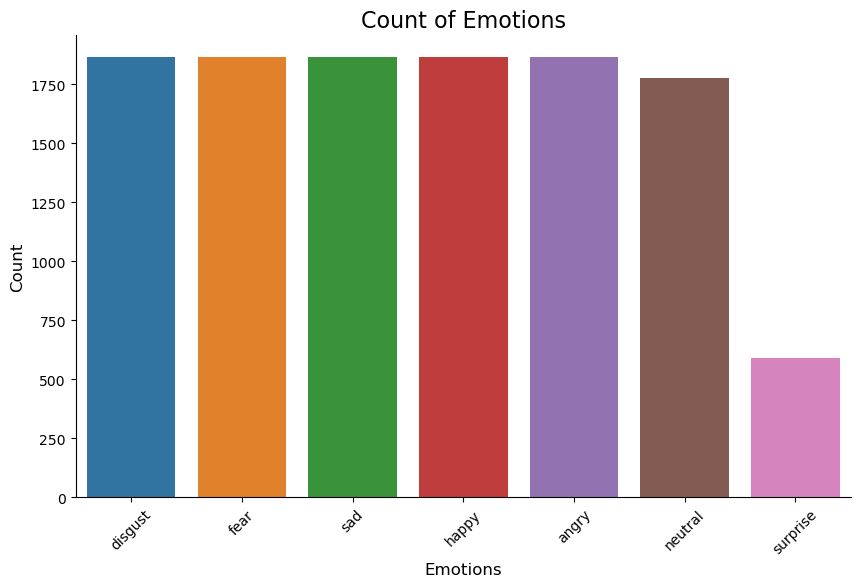

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Đếm số lần mỗi cảm xúc xuất hiện
emotion_counts = data_path['Emotions'].value_counts()

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)  # Xoay nhãn trục x nếu cần thiết
sns.despine(top=True, right=True, left=False, bottom=False)


In [12]:
data_array, sample_rate = librosa.load(data_path['Path'].iloc[0])
sample_rate
#librosa.load dùng dể lấy tốc độ lấy mẫu và array âm thanh

22050

In [13]:
ipd.Audio(data_array,rate=sample_rate)

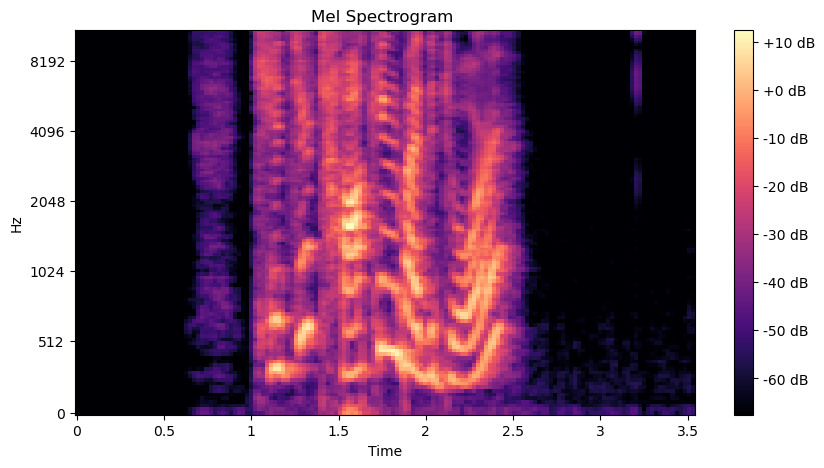

In [14]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
#melspectrogram là biểu đồ biểu diễn âm thanh dưới dạng các vách ngắn đo trong một không gian mel
spectrogram = librosa.feature.melspectrogram(y=data_array, sr=sample_rate, n_mels=128,fmax=5000) 
#chuyển đổi melspectrogram sang đơn vị Decibel
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sample_rate, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')


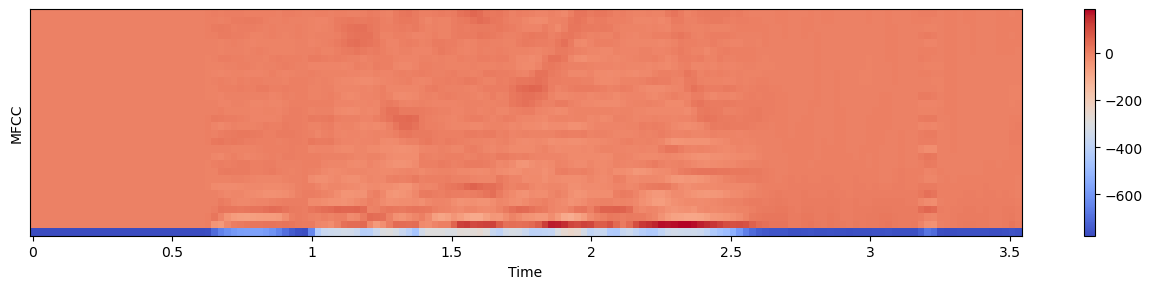

In [15]:
#tính toán các đặc trưng mfcc (mel-frequency cpestral coeffcients)
mfcc = librosa.feature.mfcc(y=data_array, sr=sample_rate, n_mfcc=30)
'''
Kết quả trả về là một ma trận có kích thước (n_mfcc, T), trong đó n_mfcc
là số lượng hệ số MFCC và T là số khung thời gian trong tín hiệu âm thanh.
Mỗi hàng của ma trận tương ứng với một hệ số MFCC và mỗi cột tương ứng với
một khung thời gian. MFCC thường được sử dụng để biểu diễn đặc trưng âm thanh
và thường được sử dụng trong các ứng dụng xử lý tiếng nói và âm nhạc.
'''
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data_array,rate=sample_rate)

### Data Augmentation

In [16]:
# NOISE- nhiễu
def noise(data):
    noise_amp = 0.045*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH-giãn
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)
# SHIFT-dịch chuyển
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH - biến đổi tần số
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

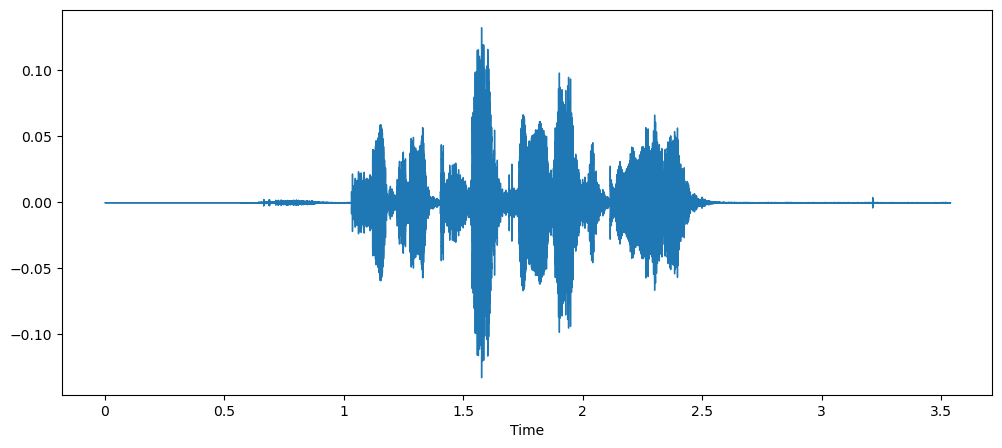

In [17]:
# audio ban đầu
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data_array, sr=sample_rate)
ipd.Audio(data_array,rate=sample_rate)

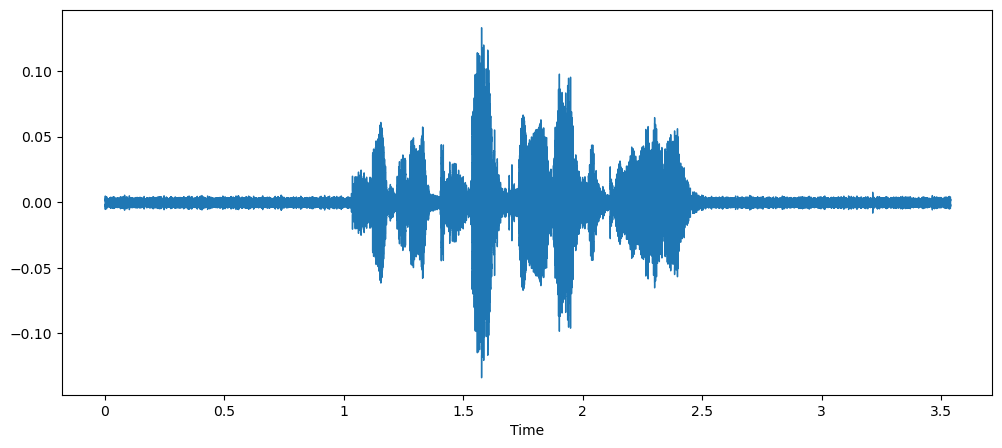

In [18]:
# AUDIO thêm nhiễu
x = noise(data_array)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

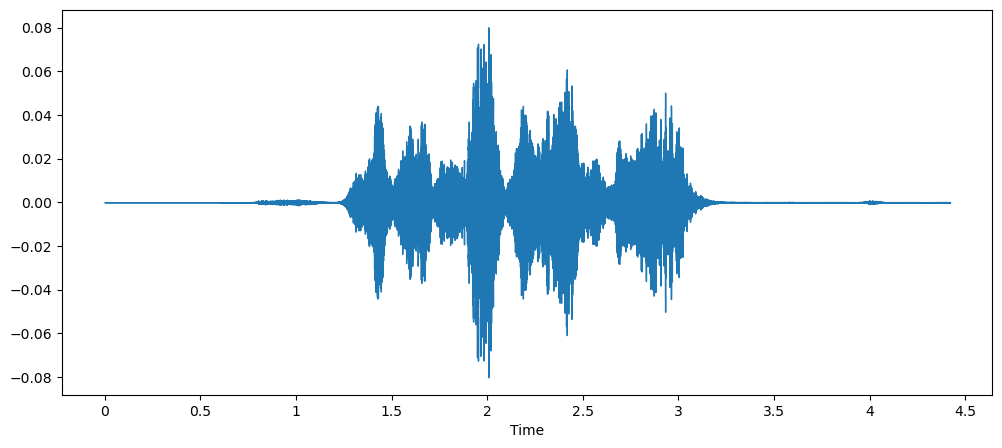

In [19]:
# audio giãn
x = stretch(data_array)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

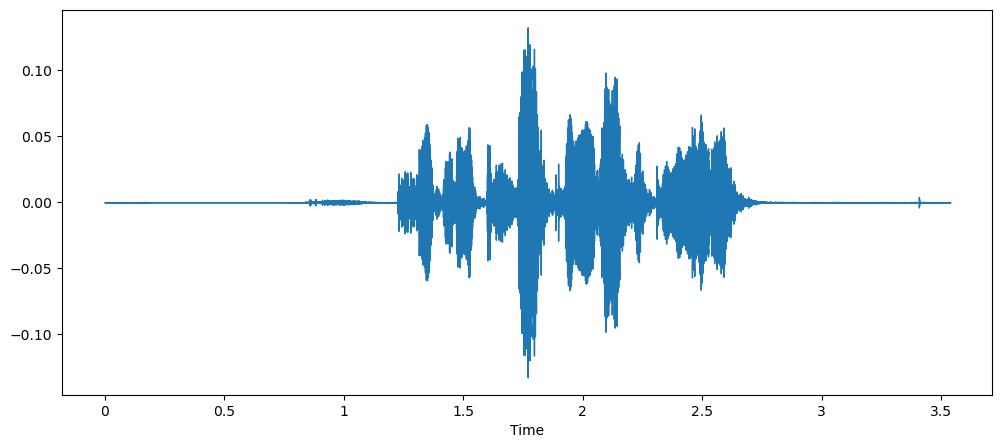

In [20]:
# audio bị dịch
x = shift(data_array)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

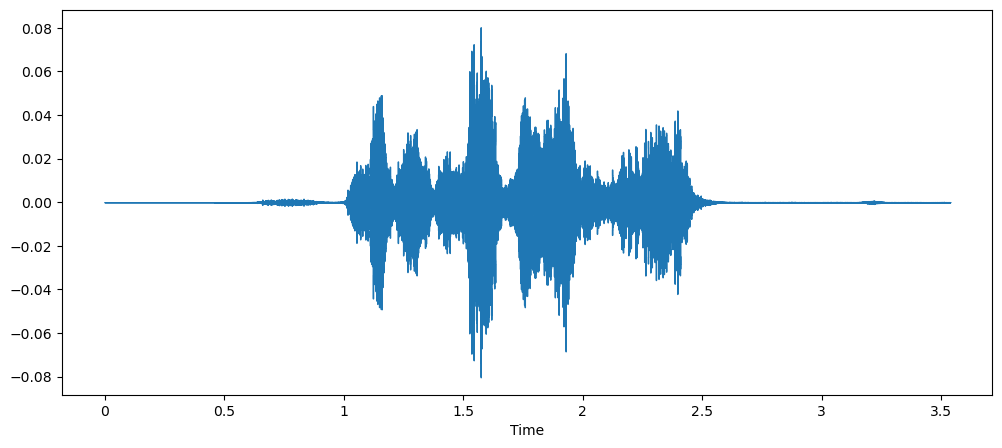

In [21]:
# audio
x = pitch(data=data_array,sampling_rate=sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

### Feature Extraction

In [22]:
# tính tỉ lệ vượt ngưỡng của dữ liệu âm thanh- trả về mảng 1 chiều
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
# hàm tính root mean square error
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
#mfcc
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)
'''
trích xuất feature Hàm này kết hợp các đặc trưng ZCR, RMSE, và MFCC
để tạo một vectơ đặc trưng hoàn chỉnh cho dữ liệu âm thanh.
'''
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path = path,duration=duration,offset=offset)
    aud=extract_features(data) # trích xuất feature
    audio=np.array(aud) # chuyển các feature thành array
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

### Get feature

In [23]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [24]:
from joblib import Parallel, delayed  # hỗ trợ tính toán sóng song
import timeit
start = timeit.default_timer()
# get feature cho từng file uadio
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# chạy vòng lặp song song 
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# điền kết quả 
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)   

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Time:  554.3394598900001


In [25]:
len(X), len(Y), data_path.Path.shape

(46728, 46728, (11682,))

### Saving features

In [26]:
emotions = pd.DataFrame(X)
emotions['Emotions'] = Y
emotions.to_csv('emotion.csv', index=False)
emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.255859,0.377930,0.510742,0.516602,0.510254,0.512695,0.513184,0.506348,0.506348,0.505371,...,-2.922745,-2.842981,-3.093361,-5.599536,-0.203435,1.714537,6.205913,7.194991,1.853438,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518294,0.838663,1.308726,1.855107,2.405185,2.896439,3.283486,3.541677,3.667473,surprise
3,0.241211,0.373047,0.502930,0.495605,0.499023,0.489746,0.488770,0.496582,0.504883,0.503906,...,3.226798,1.661371,-4.635501,-3.796865,-1.594163,0.128519,4.611383,8.297373,-1.462648,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [27]:
Emotions = pd.read_csv('/kaggle/working/emotion.csv')

In [28]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [29]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(46728, 2377)

In [30]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

### Data prepare

In [31]:
Y=Emotions['Emotions']
X= Emotions.drop('Emotions',axis= 1)

In [32]:
X.shape

(46728, 2376)

In [33]:
Y.shape

(46728,)

In [34]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [35]:
Y.shape

(46728, 7)

In [36]:
Y[0]

array([0., 0., 0., 0., 0., 0., 1.])

In [37]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=35,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [38]:
#reshape for lstm
X_train = x_train.to_numpy().reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.to_numpy().reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [39]:
X_train.shape

(37382, 2376, 1)

In [40]:
# scale data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [41]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.5,min_lr=0.00001)

### LSTM model

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Lambda
from tensorflow.keras.models import Model

# Define the input shape
input_seq = Input(shape=(x_train.shape[1], 1))

# Define your LSTM layers with return_sequences=True
lstm1 = LSTM(512, return_sequences=True)(input_seq)
dropout1 = Dropout(0.3)(lstm1)
dense1 = Dense(256, activation='relu')(dropout1)
lstm2 = LSTM(256, return_sequences=True)(dense1)
dropout2 = Dropout(0.2)(lstm2)
dense2 = Dense(128, activation='relu')(dropout2)
lstm3 = LSTM(128, return_sequences=True)(dense2)
dropout3 = Dropout(0.3)(lstm3)

# Define a custom Attention layer
def attention_layer(inputs):
    return tf.keras.layers.Attention()([inputs, inputs])

# Apply the custom attention layer
attention_output = Lambda(attention_layer)(lstm3)

# Add a final LSTM layer
lstm_final = LSTM(128)(attention_output)

# Add the output layer
output = Dense(7, activation='softmax')(lstm_final)

# Create the model
model_with_attention = Model(inputs=input_seq, outputs=output)

# Compile the model
model_with_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_with_attention.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2376, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, 2376, 512)         1052672   
                                                                 
 dropout (Dropout)           (None, 2376, 512)         0         
                                                                 
 dense (Dense)               (None, 2376, 256)         131328    
                                                                 
 lstm_1 (LSTM)               (None, 2376, 256)         525312    
                                                                 
 dropout_1 (Dropout)         (None, 2376, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 2376, 128)         32896 

In [43]:
hist=model_with_attention.fit(X_train, y_train,
            epochs=40,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)

Epoch 1/40
585/585 [==============================] - 584s 981ms/step - loss: 1.6880 - accuracy: 0.3099 - val_loss: 1.8807 - val_accuracy: 0.1874
Epoch 2/40
585/585 [==============================] - 574s 981ms/step - loss: 1.8406 - accuracy: 0.2150 - val_loss: 1.6455 - val_accuracy: 0.3257
Epoch 3/40
585/585 [==============================] - 574s 981ms/step - loss: 1.5744 - accuracy: 0.3584 - val_loss: 1.5417 - val_accuracy: 0.3671
Epoch 4/40
585/585 [==============================] - 574s 981ms/step - loss: 1.4269 - accuracy: 0.4396 - val_loss: 1.3872 - val_accuracy: 0.4527
Epoch 5/40
585/585 [==============================] - 574s 981ms/step - loss: 1.2836 - accuracy: 0.4987 - val_loss: 1.2386 - val_accuracy: 0.5186
Epoch 6/40
585/585 [==============================] - 574s 981ms/step - loss: 1.1968 - accuracy: 0.5316 - val_loss: 1.1635 - val_accuracy: 0.5376
Epoch 7/40
585/585 [==============================] - 573s 980ms/step - loss: 1.1562 - accuracy: 0.5500 - val_loss: 1.1284 -

293/293 [==============================] - 86s 293ms/step - loss: 0.7802 - accuracy: 0.6949
Accuracy of our model on test data :  69.49496865272522 %


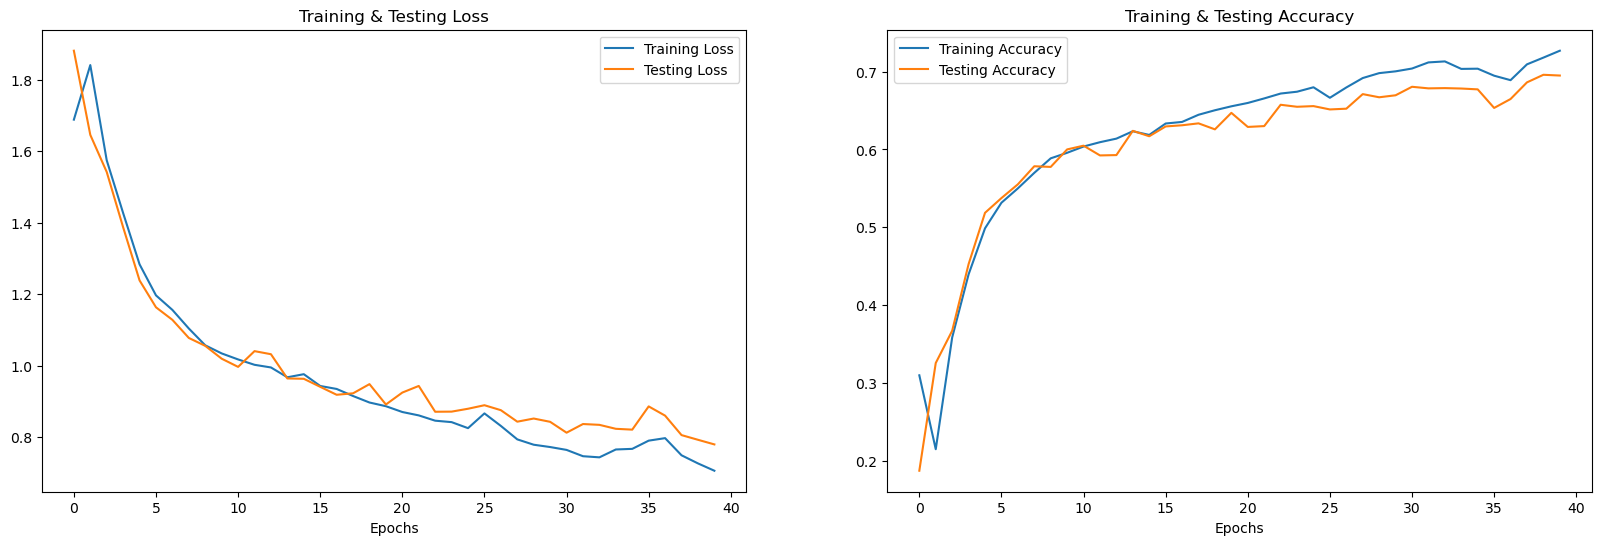

In [44]:
print("Accuracy of our model on test data : " , model_with_attention.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [46]:
# predicting on test data.
pred_test0 = model_with_attention.predict(x_test)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

293/293 [==============================] - 86s 288ms/step


,Predicted Labels,Actual Labels
0,sad,fear
1,sad,neutral
2,sad,surprise
3,sad,sad
4,sad,neutral
5,sad,happy
6,sad,fear
7,sad,disgust
8,sad,surprise
9,sad,angry


### CNN model

In [47]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((37382, 2376, 1), (37382, 7), (9346, 2376, 1), (9346, 7))

In [48]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2376, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 1188, 512)        2048      
 hNormalization)                                                 
                                                        

In [49]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=128,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
293/293 [==============================] - 109s 331ms/step - loss: 1.3721 - accuracy: 0.4798 - val_loss: 2.7077 - val_accuracy: 0.1709 - lr: 0.0010
Epoch 2/50
293/293 [==============================] - 96s 328ms/step - loss: 1.0829 - accuracy: 0.5779 - val_loss: 1.3705 - val_accuracy: 0.4516 - lr: 0.0010
Epoch 3/50
293/293 [==============================] - 96s 328ms/step - loss: 0.9639 - accuracy: 0.6274 - val_loss: 1.0348 - val_accuracy: 0.5941 - lr: 0.0010
Epoch 4/50
293/293 [==============================] - 96s 328ms/step - loss: 0.8540 - accuracy: 0.6746 - val_loss: 1.0335 - val_accuracy: 0.6037 - lr: 0.0010
Epoch 5/50
293/293 [==============================] - 96s 328ms/step - loss: 0.7585 - accuracy: 0.7120 - val_loss: 0.8470 - val_accuracy: 0.6740 - lr: 0.0010
Epoch 6/50
293/293 [==============================] - 96s 327ms/step - loss: 0.6698 - accuracy: 0.7470 - val_loss: 0.8981 - val_accuracy: 0.6523 - lr: 0.0010
Epoch 7/50
293/293 [==============================]

293/293 [==============================] - 7s 23ms/step - loss: 0.1451 - accuracy: 0.9609
Accuracy of our model on test data :  96.09458446502686 %


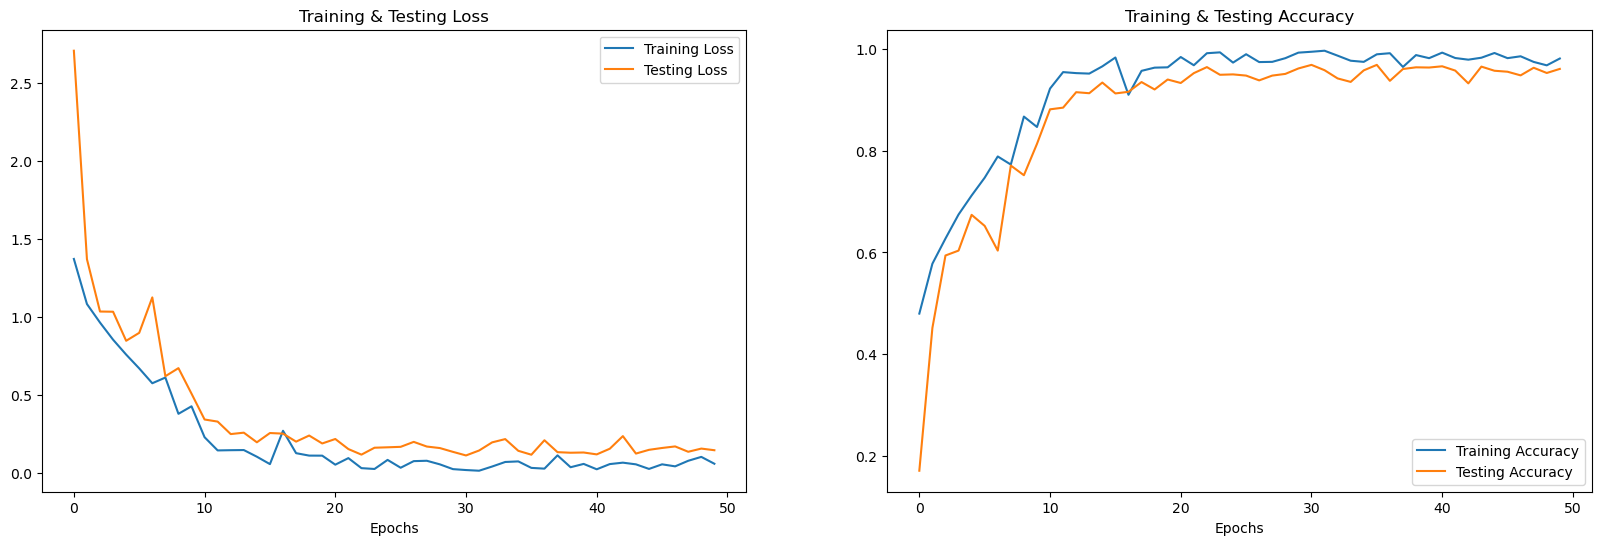

In [51]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [53]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

293/293 [==============================] - 6s 21ms/step


,Predicted Labels,Actual Labels
0,fear,fear
1,neutral,neutral
2,surprise,surprise
3,sad,sad
4,neutral,neutral
5,happy,happy
6,sad,fear
7,disgust,disgust
8,surprise,surprise
9,angry,angry


### CLSTM

In [54]:
model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

          
model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dense(512, activation='relu'))
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dense(256, activation='relu'))
model000.add(Dropout(0.3))
          
model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2376, 1024)        6144      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1188, 1024)       0         
 1D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 1188, 1024)       4096      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 1188, 1024)        0         
                                                                 
 conv1d_6 (Conv1D)           (None, 1188, 512)         2621952   
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 594, 512)        

In [55]:
model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
hist1=model000.fit(x_traincnn, y_train, batch_size=128, epochs=50, validation_data=(x_testcnn, y_test))

Epoch 1/50
293/293 [==============================] - 171s 543ms/step - loss: 1.8209 - accuracy: 0.2393 - val_loss: 2.0106 - val_accuracy: 0.1609
Epoch 2/50
293/293 [==============================] - 157s 536ms/step - loss: 1.8001 - accuracy: 0.2492 - val_loss: 1.9700 - val_accuracy: 0.2075
Epoch 3/50
293/293 [==============================] - 157s 536ms/step - loss: 1.7179 - accuracy: 0.2962 - val_loss: 1.6799 - val_accuracy: 0.3146
Epoch 4/50
293/293 [==============================] - 157s 536ms/step - loss: 1.6713 - accuracy: 0.3205 - val_loss: 1.6165 - val_accuracy: 0.3329
Epoch 5/50
293/293 [==============================] - 157s 537ms/step - loss: 1.6172 - accuracy: 0.3440 - val_loss: 1.5798 - val_accuracy: 0.3541
Epoch 6/50
293/293 [==============================] - 157s 537ms/step - loss: 1.5955 - accuracy: 0.3540 - val_loss: 1.5794 - val_accuracy: 0.3579
Epoch 7/50
293/293 [==============================] - 157s 537ms/step - loss: 1.5614 - accuracy: 0.3701 - val_loss: 1.5466 -

293/293 [==============================] - 16s 52ms/step - loss: 0.8634 - accuracy: 0.6678
Accuracy of our model on test data :  66.77722930908203 %


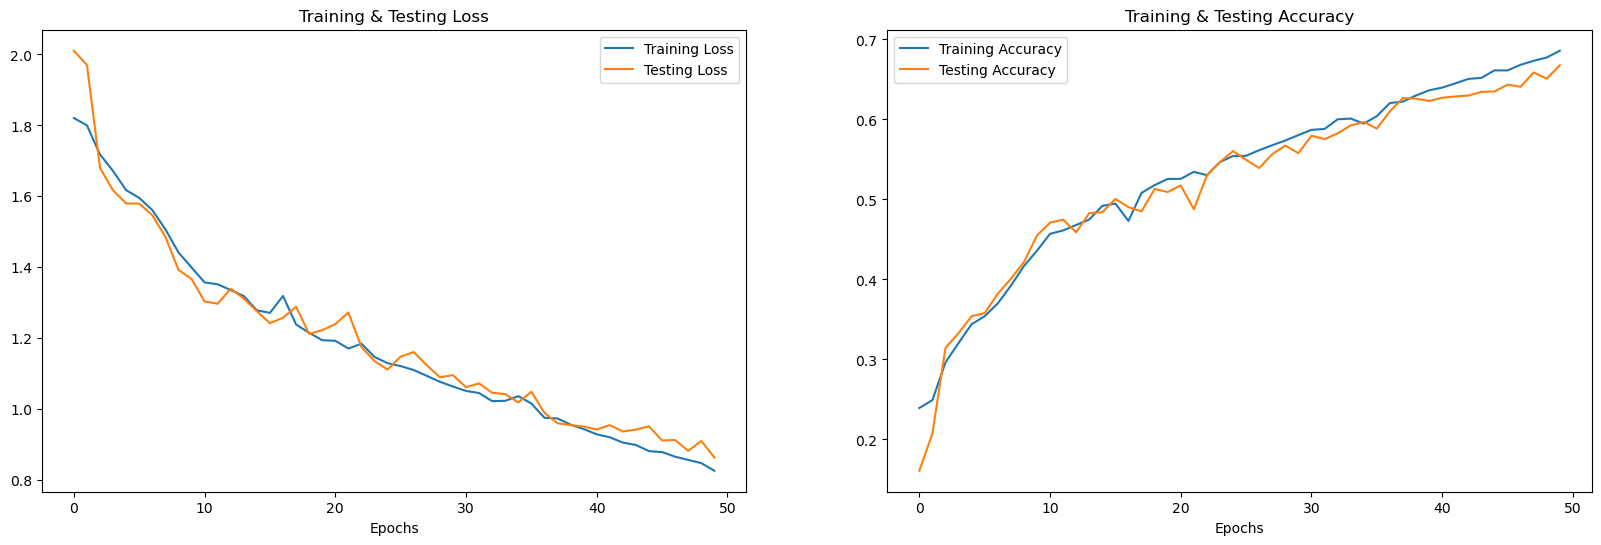

In [57]:
print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [58]:
# predicting on test data.
pred_test0 = model000.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

293/293 [==============================] - 16s 50ms/step


,Predicted Labels,Actual Labels
0,fear,fear
1,neutral,neutral
2,surprise,surprise
3,sad,sad
4,neutral,neutral
5,surprise,happy
6,sad,fear
7,sad,disgust
8,surprise,surprise
9,angry,angry


In [59]:
import requests

# Đường dẫn URL của notebook trên Kaggle
url = 'https://www.kaggle.com/code/nhtanhnguyn0029/speech-emotion-recognition/edit/run/148891178'

# Tên tệp bạn muốn lưu notebook
output_file = 'speech_emotion_recognition.ipynb'

# Sử dụng thư viện requests để tải notebook từ URL
response = requests.get(url)

if response.status_code == 200:
    # Lưu nội dung tải về thành một tệp
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print(f'Tải notebook thành công và lưu thành tệp {output_file}')
else:
    print(f'Tải notebook thất bại. Mã trạng thái HTTP: {response.status_code}')


Tải notebook thành công và lưu thành tệp speech_emotion_recognition.ipynb
